In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import re
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from classify_campaigns import classify_campaigns

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [4]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')
imp_type

impression type  imp_type_id
0          display            1
1            video            2
2           native            4
3     native video            8
4   rewarded video           16
5              IBV           32
6  rewarded banner           64

In [6]:
start_dt = '2021-06-30'
end_dt = '2021-07-20'


30% drop in performance, figuring out if this was from:
 
- APK issue (7/8-11)

- audience update

- general down trend

In [7]:
df = bigquery_client.query(f"""
select
    r.date
    , extract(date from r.etimestamp) as edate
    , case when r.deal_id = 'Appreciate_Tripledot' then r.deal_id else NULL end as deal_id
    , case when r.ctr_model = 'production' or r.cr_model = 'production' then 'AP' else 'ML' end as model
    , c.name as campaign_name    
    , r.ssb_campaign_uuid
    , r.ssb_buyer_id
    , r.sponsored_app_id
    , r.exploration_uuid
    , p.name as sponsored_app_name
    , r.exchange_id
    , r.hosting_app_id
    , ho.name as hosting_app_name
    , p.bundle as sponsored_bnd
    , ad_type
    , imp_type
    , os_version_text
    , count(case when event_type = 'clear' then 1 else NULL end)*2 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*2 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*2 as installs
    , sum(case when event_type = 'install' then revenue else 0 end)*2 as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*2/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)*2/1000 as bid
    , 0 as d1_retent
    , 0 as d7_retent
from stats.rows1 r
join metadata.campaigns c
    on r.ssb_campaign_uuid = c.uuid  
    and c.name like '%News Break%'
join metadata.apps p
    on r.sponsored_app_id = p.app_id
join metadata.apps ho
    on r.hosting_app_id = ho.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and right(r.id,1) in ('0','1','2','3','4','5','6','7')
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17

union all

select
    i.date
    , i.edate
    , i.deal_id
    , i.model
    , i.campaign_name    
    , i.ssb_campaign_uuid
    , i.ssb_buyer_id
    , i.sponsored_app_id
    , i.exploration_uuid
    , i.sponsored_app_name
    , i.exchange_id
    , i.hosting_app_id
    , i.hosting_app_name
    , i.sponsored_bnd
    , i.ad_type
    , i.imp_type
    , i.os_version_text
    , 0 as impressions
    , 0 as clicks
    , 0 as installs
    , 0 as spend
    , 0 as cost
    , 0 as bid
    , count(distinct case when date_diff(extract(date from r.etimestamp), i.date, day) = 1 then i.tid else NULL end) as d1_retent
    , count(distinct case when date_diff(extract(date from r.etimestamp), i.date, day) = 7 then i.tid else NULL end) as d7_retent
FROM `apprec-prod.stats.rows1` r
JOIN `apprec-prod.stats.mv_unique3` m
USING
  (id)
join
(
    select 
        r.id
        , r.tid
        , r.date
        , extract(date from r.etimestamp) as edate
        , case when r.deal_id = 'Appreciate_Tripledot' then r.deal_id else NULL end as deal_id
        , case when r.ctr_model = 'production' or r.cr_model = 'production' then 'AP' else 'ML' end as model
        , c.name as campaign_name    
        , r.ssb_campaign_uuid
        , r.ssb_buyer_id
        , r.sponsored_app_id
        , r.exploration_uuid
        , r.os_version_text
        , p.name as sponsored_app_name
        , r.exchange_id
        , r.hosting_app_id
        , ho.name as hosting_app_name
        , p.bundle as sponsored_bnd
        , ad_type
        , imp_type
    from stats.rows1 r
    join metadata.campaigns c
        on r.ssb_campaign_uuid = c.uuid  
        and c.name like '%News Break%'
    join metadata.apps p
        on r.sponsored_app_id = p.app_id
    join metadata.apps ho
        on r.hosting_app_id = ho.app_id
    where 
        extract(date from etimestamp) >= '{start_dt}'
        and extract(date from etimestamp) <= '{end_dt}'
        and event_type = 'install'
        and r.ssb_buyer_id = 3549
) i 
    on r.id = i.id
WHERE
    m.date >= '{start_dt}' - 30
    and m.date <= '{end_dt}'
    and extract(date from r.etimestamp) >= '{start_dt}' 
    and extract(date from r.etimestamp) <= '{end_dt}' + 7
    and date_diff(extract(date from r.etimestamp), i.date, day) in (1,7)
    and r.event_type = 'pie' 
    and r.ename = 'af_app_opened'
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
""").to_dataframe()
df = df.set_index('imp_type').join(imp_type.set_index('imp_type_id'), how = 'left').reset_index()
df = df.set_index('exchange_id').join(exchange.set_index('exchange_id'), how = 'left').reset_index()
df['experience_type'] = df.apply(lambda x:classify_campaigns(x), axis = 1)
df['media_cost'] = 1.25*df['cost']
df['week'] = pd.to_datetime(df['date']).dt.week
df['eweek'] = pd.to_datetime(df['edate']).dt.week
df

exchange_id  index        date       edate deal_id model  \
0                  1    1.0  2021-07-15  2021-07-15    None    AP   
1                  1    1.0  2021-07-16  2021-07-16    None    AP   
2                  1    1.0  2021-07-16  2021-07-16    None    AP   
3                  1    1.0  2021-07-16  2021-07-16    None    AP   
4                  1    1.0  2021-07-16  2021-07-16    None    AP   
...              ...    ...         ...         ...     ...   ...   
2670317           59    4.0  2021-07-11  2021-07-11    None    ML   
2670318           59    4.0  2021-07-03  2021-07-03    None    ML   
2670319           59    4.0  2021-07-03  2021-07-03    None    ML   
2670320           59    4.0  2021-07-19  2021-07-19    None    ML   
2670321           59    4.0  2021-07-11  2021-07-11    None    ML   

                                             campaign_name  \
0                         Particle Media-News Break-US-iOS   
1                         Particle Media-News Break-US-iOS   
2                         Particle Media-News Break-US-iOS   
3                         Particle Media-News Break-US-iOS   
4                         Particle Media-News Break-US-iOS   
...                                                    ...   
2670317  Particle Media – News Break – US – All – GP - ...   
2670318  Particle Media – News Break – US – All – GP - ...   
2670319  Particle Media – News Break – US – All – GP - ...   
2670320  Particle Media – News Break – US – All – GP - ...   
2670321  Particle Media – News Break – US – All – GP - ...   

                        ssb_campaign_uuid  ssb_buyer_id  sponsored_app_id  \
0        f1d182a7fabffea0694ae7287aa26c0d          3549        1132762804   
1        f1d182a7fabffea0694ae7287aa26c0d          3549        1132762804   
2        f1d182a7fabffea0694ae7287aa26c0d          3549        1132762804   
3        f1d182a7fabffea0694ae7287aa26c0d          3549        1132762804   
4        f1d182a7fabffea0694ae7287aa26c0d          3549        1132762804   
...                                   ...           ...               ...   
2670317  16d935fca4ea8b4dffa296ba147ec7df          3549            951372   
2670318  16d935fca4ea8b4dffa296ba147ec7df          3549            951372   
2670319  16d935fca4ea8b4dffa296ba147ec7df          3549            951372   
2670320  16d935fca4ea8b4dffa296ba147ec7df          3549            951372   
2670321  16d935fca4ea8b4dffa296ba147ec7df          3549            951372   

         ...      cost       bid  d1_retent d7_retent impression type  \
0        ...  0.001741  0.001744          0         0         display   
1        ...  0.006459  0.006589          0         0         display   
2        ...  0.002644  0.002759          0         0         display   
3        ...  0.003300  0.003300          0         0         display   
4        ...  0.001032  0.001059          0         0         display   
...      ...       ...       ...        ...       ...             ...   
2670317  ...  0.009144  0.009145          0         0          native   
2670318  ...  0.017126  0.017127          0         0          native   
2670319  ...  0.002436  0.002436          0         0          native   
2670320  ...  0.000772  0.000771          0         0          native   
2670321  ...  0.035240  0.035241          0         0          native   

        exchange_name experience_type  media_cost  week  eweek  
0               Fyber               4    0.002177    28     28  
1               Fyber               4    0.008074    28     28  
2               Fyber               4    0.003305    28     28  
3               Fyber               4    0.004125    28     28  
4               Fyber               4    0.001290    28     28  
...               ...             ...         ...   ...    ...  
2670317       Samsung               3    0.011430    27     27  
2670318       Samsung               3    0.021407    26     26  
2670319       Samsung               3    0.00304

In [8]:
df_offers = bigquery_client.query(f"""
select
    *
from metadata.offers
""").to_dataframe()
json_struct = df_offers['extra_data'].apply(json.loads)
df_offers_flat = pd.io.json.json_normalize(json_struct) 
df_offers_joined = df_offers.join(df_offers_flat,rsuffix='_extra')
df_offers_joined.drop(['extra_data'], axis = 1, inplace = True)
df_offers_joined.rename(columns = {'ssb_campaign_uuid':'uuid'}, inplace = True)
df_offers_joined#.to_csv(f'~/Downloads/offers_{end_dt}.csv', index = False)

package_name user_defined_type         type  form_factor  \
0                     1096944783       app install  OfferCustom            1   
1                      297606951       app install  OfferCustom            1   
2                      604044220       app install  OfferCustom            1   
3                      966810173       app install  OfferCustom            1   
4                      406889139       app install  OfferCustom            1   
...                          ...               ...          ...          ...   
11254  com.unicostudio.braintest       app install  OfferCustom           10   
11255                       None            custom  OfferCustom           10   
11256                       None            custom  OfferCustom           10   
11257                       None            custom  OfferCustom           10   
11258                       None            custom  OfferCustom           10   

      country status                updated_at  ssb_buyer_id  \
0          US     up 2016-12-25 16:42:28+00:00             1   
1          RU     up 2018-01-10 12:19:41+00:00             1   
2          US     up 2020-04-27 08:12:49+00:00             1   
3          RU     up 2018-03-28 14:55:07+00:00             1   
4          US     up 2019-07-22 09:24:49+00:00             1   
...       ...    ...                       ...           ...   
11254      US     up 2021-04-06 11:56:08+00:00          3669   
11255      IQ     up 2021-02-04 07:59:48+00:00          3734   
11256      IQ     up 2021-02-05 20:42:47+00:00          3734   
11257      IQ     up 2021-02-26 08:32:47+00:00          3734   
11258      IQ     up 2021-03-11 07:05:49+00:00          3734   

      affiliate_network    cpi  ...  auto_pilot_cpa_factor custom_categories  \
0                  None   1.05  ...                    NaN               NaN   
1                  None   0.10  ...                    NaN               NaN   
2                  None   1.25  ...                    NaN               NaN   
3                  None   6.50  ...                    NaN               NaN   
4                  None  24.00  ...                    NaN               NaN   
...                 ...    ...  ...                    ...               ...   
11254              None   0.90  ...                    NaN               NaN   
11255              None   0.90  ...                    NaN               NaN   
11256              None   0.90  ...                    NaN               NaN   
11257              None   0.90  ...                    NaN               NaN   
11258              None   0.90  ...                    NaN               NaN   

      custom_click_url  tags app_icon  alternative_landing_url  \
0                  NaN   NaN      NaN                      NaN   
1                  NaN   NaN      NaN                      NaN   
2                  NaN   NaN      NaN                      NaN   
3                  NaN   NaN      NaN                      NaN   
4                  NaN   NaN      NaN                      NaN   
...                ...   ...      ...                      ...   
11254              NaN   NaN      NaN                      NaN   
11255              NaN   NaN      NaN                      NaN   
11256              NaN   NaN      NaN                      NaN   
11257              NaN   NaN      NaN                      NaN   
11258              NaN   NaN      NaN                      NaN   

      optimization_cohort_action_name optimization_action_revenue_goal_perct  \
0                                 NaN                                    NaN   
1                                 NaN                                    NaN   
2                                 NaN                                    NaN   
3                                 NaN                                    NaN   
4                                 NaN                                    NaN   
...                               ...                   

In [9]:
def calc_metrics(df, sov_base = 0):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['cpm'] = 1000*df['media_cost']/df['impressions']
    df['rpi'] = df['spend']/df['installs']
    df['margin'] = 100*(df['spend']-df['media_cost'])/df['spend']
    df['d1_rr'] = 100*df['d1_retent']/df['installs']
    df['cost_per_d1_retent'] = df['spend']/df['d1_retent']
    df['d7_rr'] = 100*df['d7_retent']/df['installs']
    df['cost_per_d7_retent'] = df['spend']/df['d7_retent']
    if sov_base == 0:
        df['media_cost_sov'] = 100*df['media_cost']/df['media_cost'].sum()
        df['spend_sov'] = 100*df['spend']/df['spend'].sum()
    else:
        df['media_cost_sov'] = 100*df['media_cost']/df.groupby(sov_base)['media_cost'].transform(sum)
        df['spend_sov'] = 100*df['spend']/df.groupby(sov_base)['spend'].transform(sum)
    return df[['impressions','clicks','ctr','installs','ir','ipm','cpm','rpi','spend','spend_sov','media_cost','media_cost_sov','margin','d1_retent','d1_rr','cost_per_d1_retent','d7_retent','d7_rr','cost_per_d7_retent']]

format_map = {'impressions':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'d7_retent':'{:,.0f}'
             ,'spend':'${:,.0f}'
             ,'media_cost':'${:,.0f}'
             ,'d1_rr':'{:,.0f}%'
             ,'d7_rr':'{:,.0f}%'
             ,'cost_per_d1_retent':'${:,.2f}'
             ,'cost_per_d7_retent':'${:,.2f}'
             ,'rpi':'${:,.2f}'
             ,'cpm':'${:,.2f}'
             ,'ctr':'{:,.1f}%'
             ,'ir':'{:,.1f}%'
             ,'ipm':'{:,.2f}'
             ,'spend_sov':'{:,.0f}%'
             ,'margin':'{:,.0f}%'
             ,'media_cost_sov':'{:,.0f}%'}

In [10]:
i = ['date']
filters = (df.date >= datetime.date(2021,6,30)) & (df.date <= datetime.date(2021,7,27))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot)
# format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])


In [11]:
fig, ax = plt.subplots(3,1, figsize = (12,13))
ax[0].plot(format_pivot[['spend']])
ax[0].legend(['spend'])
ax[1].plot(format_pivot[['cost_per_d1_retent','cost_per_d7_retent']])
ax[1].legend(['cost_per_d1_retent','cost_per_d7_retent'])
ax[2].plot(format_pivot[['d1_rr','d7_rr']])
ax[2].legend(['d1_rr','d7_rr'])
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))

In [12]:
i = ['edate']
filters = (df.edate >= datetime.date(2021,6,30)) & (df.edate <= datetime.date(2021,7,27))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot)
# format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])


In [13]:
format_pivot.index = pd.to_datetime(format_pivot.index)
fig, ax = plt.subplots(3,1, figsize = (12,13))
ax[0].plot(format_pivot[['spend']])
ax[0].legend(['spend'])
ax[1].plot(format_pivot[['cost_per_d1_retent','cost_per_d7_retent']])
ax[1].legend(['cost_per_d1_retent','cost_per_d7_retent'])
ax[2].plot(format_pivot[['d1_rr','d7_rr']])
ax[2].legend(['d1_rr','d7_rr'])
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))

Can the cohort date cause significant discrepancy?

In [14]:
df['days_since_bid'] = df.edate - df.date
pivot = df.groupby('days_since_bid')['installs'].sum().to_frame()
pivot['install_sov'] = 100*pivot.installs/pivot.installs.sum()
pivot.style.format({'installs':'{:,.0f}','install_sov':'{:,.0f}%'})

In [15]:
df[['week','date']].drop_duplicates().sort_values('date')

week        date
182997    25  2021-06-23
68011     25  2021-06-24
41635     25  2021-06-25
68638     25  2021-06-26
37299     25  2021-06-27
37314     26  2021-06-28
878       26  2021-06-29
8         26  2021-06-30
17        26  2021-07-01
59        26  2021-07-02
30        26  2021-07-03
19        26  2021-07-04
23        27  2021-07-05
26        27  2021-07-06
34        27  2021-07-07
53        27  2021-07-08
18        27  2021-07-09
9         27  2021-07-10
12        27  2021-07-11
13        28  2021-07-12
15        28  2021-07-13
28        28  2021-07-14
0         28  2021-07-15
1         28  2021-07-16
5         28  2021-07-17
21        28  2021-07-18
27        29  2021-07-19
7         29  2021-07-20

In [16]:
i = ['campaign_name','week']
filters = (df.week.isin([28,29]))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, i[1])
format_pivot['total_media_cost'] = format_pivot.groupby(i[0])['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

In [17]:
i = ['os_major']
df['os_major'] = df['os_version_text'].str.split('.').str[0]

filters = (df.week.isin([28,29]))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot,0)
format_pivot.sort_values('media_cost_sov',ascending = False, inplace = True)
format_pivot[format_pivot.media_cost_sov>.01].head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

In [18]:
i = ['experience_type','week']
filters = (df.week.isin([28,29]))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, i[1])
format_pivot['total_media_cost'] = format_pivot.groupby(i[0])['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

In [19]:
i = ['impression type','ad_type','week']
filters = (df.week.isin([28,29]))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'week')
format_pivot['total_media_cost'] = format_pivot.groupby(i[:-1])['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

the drop is almost all types

In [20]:
i = ['hosting_app_name','week']
filters = (df.week.isin([28,29]))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'week')
format_pivot['total_media_cost'] = format_pivot.groupby(i[:-1])['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

In [21]:
df['deal_id'] = df['deal_id'].fillna(-1)

In [22]:
i = ['deal_id','week']
filters = (df.week.isin([28,29]))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'week')
format_pivot['total_media_cost'] = format_pivot.groupby(i[:-1])['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

In [23]:
i = ['model','week']
filters = (df.week.isin([28,29]))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'week')
format_pivot['total_media_cost'] = format_pivot.groupby(i[:-1])['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

In [24]:
i = ['exchange_name','week']
filters = (df.week.isin([28,29]))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'week')
format_pivot['total_media_cost'] = format_pivot.groupby(i[:-1])['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

In [25]:
i = ['campaign_name','exchange_name','week']
filters = (df.week.isin([28,29])) & (df.campaign_name == 'Particle Media - News Break - US - Tracfone PR')
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'week')
format_pivot['total_media_cost'] = format_pivot.groupby(i[:-1])['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

In [26]:
df.columns

Index(['exchange_id', 'index', 'date', 'edate', 'deal_id', 'model',
       'campaign_name', 'ssb_campaign_uuid', 'ssb_buyer_id',
       'sponsored_app_id', 'exploration_uuid', 'sponsored_app_name',
       'hosting_app_id', 'hosting_app_name', 'sponsored_bnd', 'ad_type',
       'os_version_text', 'impressions', 'clicks', 'installs', 'spend', 'cost',
       'bid', 'd1_retent', 'd7_retent', 'impression type', 'exchange_name',
       'experience_type', 'media_cost', 'week', 'eweek', 'days_since_bid',
       'os_major'],
      dtype='object')

# Date based changes

In [27]:
# pacing from ASAP to equal, lowered bid factor on 7/20
group_1 = ['Particle Media - News Break - US - ATT PR','Particle Media - News Break - US - ATT UA','Particle Media - News Break - US - Cricket PR',
           'Particle Media - News Break - US - USCC UA','Particle Media - News Break - US - VZW PR']

# pacing from ASAP to equal on 7/20
group_2 = ['Particle Media - News Break - US - Tracfone PR','Particle Media - News Break - US - USCC PR',
          'Particle Media – News Break – US – All – GP2','Particle Media – News Break – US – All – GP - Display',
           'Particle Media – News Break – US – All – GP2 - video']

# pacing from ASAP to equal on 7/20, lowered bid factor on 7/23
group_3 = ['Particle Media - News Break - US - Cricket UA','Particle Media - News Break - US - Tracfone UA']

# increased bid factor on 7/21
group_4 = ['Particle Media-News Break-US-iOS']

# no changes 
group_5 = ['Particle Media - News Break - US - VZW UA']

In [28]:
i = ['date']
filters = (df.week.isin([28,29])) & (df.campaign_name.isin(group_1))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot['total_media_cost'] = format_pivot.groupby(i[0])['media_cost'].transform(sum)
print('Group 1 - pacing from ASAP to equal, lowered bid factor on 7/20')
# format_pivot.sort_values(['total_media_cost','date'], ascending = [False,True], inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

Group 1 - pacing from ASAP to equal, lowered bid factor on 7/20


In [29]:
format_pivot.index = pd.to_datetime(format_pivot.index)
fig, ax = plt.subplots(3,1, figsize = (12,13))
fig.suptitle('Group 1 - pacing from ASAP to equal, lowered bid factor on 7/20')
ax[0].plot(format_pivot[['spend']])
ax[0].legend(['spend'])
ax[0].axvline(x = datetime.date(2021,7,20), color = 'green')
ax[1].plot(format_pivot[['cost_per_d1_retent','cost_per_d7_retent']])
ax[1].legend(['cost_per_d1_retent','cost_per_d7_retent'])
ax[1].axvline(x = datetime.date(2021,7,20), color = 'green')
ax[2].plot(format_pivot[['d1_rr','d7_rr']])
ax[2].legend(['d1_rr','d7_rr'])
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[2].axvline(x = datetime.date(2021,7,20), color = 'green')

In [30]:
# ['exchange_id', 'index', 'date', 'edate', 'deal_id', 'model',
#        'campaign_name', 'ssb_campaign_uuid', 'ssb_buyer_id',
#        'sponsored_app_id', 'exploration_uuid', 'sponsored_app_name',
#        'hosting_app_id', 'hosting_app_name', 'sponsored_bnd', 'ad_type',
#        'impressions', 'clicks', 'installs', 'spend', 'cost', 'bid',
#        'd1_retent', 'd7_retent', 'impression type', 'exchange_name',
#        'experience_type', 'media_cost', 'week', 'eweek', 'days_since_bid']
i = ['impression type','ad_type','week']
filters = (df.week.isin([28,29])) & (df.campaign_name.isin(group_1))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'week')
format_pivot['total_media_cost'] = format_pivot.groupby(i[:-1])['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

In [31]:
i = ['date']
filters = (df.week.isin([28,29])) & (df.campaign_name.isin(group_2))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot['total_media_cost'] = format_pivot.groupby(i[0])['media_cost'].transform(sum)
print('Group 2 - pacing from ASAP to equal on 7/20')
# format_pivot.sort_values(['total_media_cost','date'], ascending = [False,True], inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

Group 2 - pacing from ASAP to equal on 7/20


In [32]:
format_pivot.index = pd.to_datetime(format_pivot.index)
fig, ax = plt.subplots(3,1, figsize = (12,13))
fig.suptitle('Group 2 - pacing from ASAP to equal on 7/20')
ax[0].plot(format_pivot[['spend']])
ax[0].legend(['spend'])
ax[0].axvline(x = datetime.date(2021,7,20), color = 'green')
ax[1].plot(format_pivot[['cost_per_d1_retent','cost_per_d7_retent']])
ax[1].legend(['cost_per_d1_retent','cost_per_d7_retent'])
ax[1].axvline(x = datetime.date(2021,7,20), color = 'green')
ax[2].plot(format_pivot[['d1_rr','d7_rr']])
ax[2].legend(['d1_rr','d7_rr'])
ax[2].axvline(x = datetime.date(2021,7,20), color = 'green')
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))

In [33]:
i = ['date']
filters = (df.week.isin([28,29])) & (df.campaign_name.isin(group_3))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot['total_media_cost'] = format_pivot.groupby(i[0])['media_cost'].transform(sum)
print('Group 3 - pacing from ASAP to equal on 7/20, lowered bid factor on 7/23')
# format_pivot.sort_values(['total_media_cost','date'], ascending = [False,True], inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

Group 3 - pacing from ASAP to equal on 7/20, lowered bid factor on 7/23


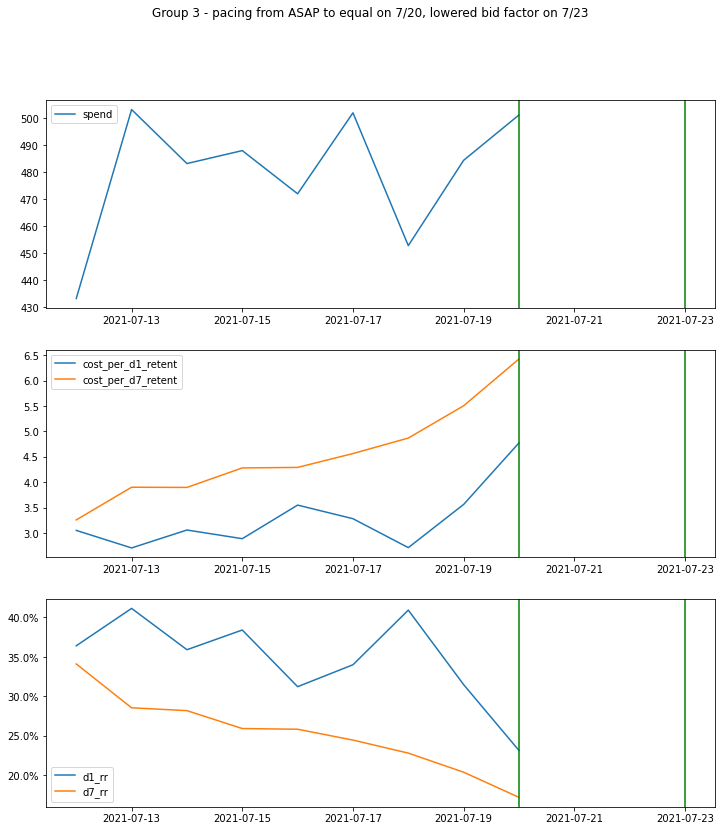

In [34]:
format_pivot.index = pd.to_datetime(format_pivot.index)
fig, ax = plt.subplots(3,1, figsize = (12,13))
fig.suptitle('Group 3 - pacing from ASAP to equal on 7/20, lowered bid factor on 7/23')
ax[0].plot(format_pivot[['spend']])
ax[0].legend(['spend'])
ax[0].axvline(x = datetime.date(2021,7,20), color = 'green')
ax[0].axvline(x = datetime.date(2021,7,23), color = 'green')
ax[1].plot(format_pivot[['cost_per_d1_retent','cost_per_d7_retent']])
ax[1].legend(['cost_per_d1_retent','cost_per_d7_retent'])
ax[1].axvline(x = datetime.date(2021,7,20), color = 'green')
ax[1].axvline(x = datetime.date(2021,7,23), color = 'green')
ax[2].plot(format_pivot[['d1_rr','d7_rr']])
ax[2].legend(['d1_rr','d7_rr'])
ax[2].axvline(x = datetime.date(2021,7,20), color = 'green')
ax[2].axvline(x = datetime.date(2021,7,23), color = 'green')
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))

In [35]:
i = ['campaign_name','date']
filters = (df.week.isin([28,29])) & (df.campaign_name.isin(group_3))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot['total_media_cost'] = format_pivot.groupby(i[0])['media_cost'].transform(sum)
print('Group 3 - pacing from ASAP to equal on 7/20, lowered bid factor on 7/23')
# format_pivot.sort_values(['total_media_cost','date'], ascending = [False,True], inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

Group 3 - pacing from ASAP to equal on 7/20, lowered bid factor on 7/23


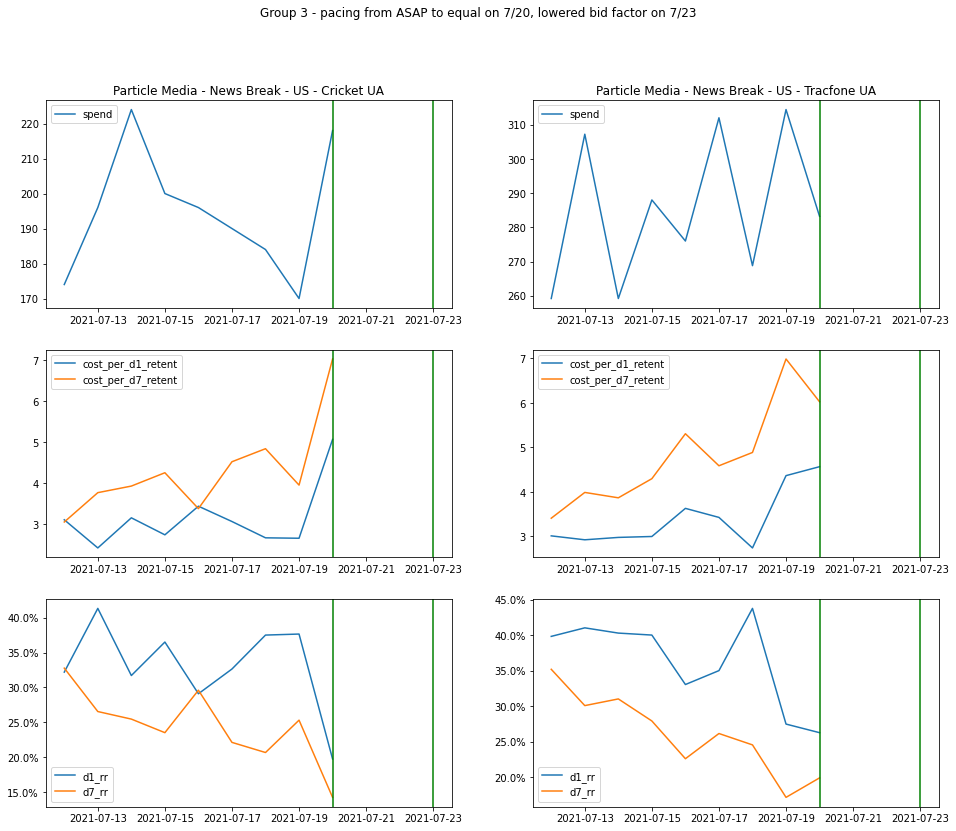

In [36]:
fig, ax = plt.subplots(3,2, figsize = (16,13))
fig.suptitle('Group 3 - pacing from ASAP to equal on 7/20, lowered bid factor on 7/23')
ax[0,0].plot(format_pivot.loc[format_pivot.index.get_level_values(0) == 'Particle Media - News Break - US - Cricket UA',['spend']].droplevel(0))
ax[0,0].legend(['spend'])
ax[0,0].axvline(x = datetime.date(2021,7,20), color = 'green')
ax[0,0].axvline(x = datetime.date(2021,7,23), color = 'green')
ax[0,0].set_title('Particle Media - News Break - US - Cricket UA')
ax[1,0].plot(format_pivot.loc[format_pivot.index.get_level_values(0) == 'Particle Media - News Break - US - Cricket UA',['cost_per_d1_retent','cost_per_d7_retent']].droplevel(0))
ax[1,0].legend(['cost_per_d1_retent','cost_per_d7_retent'])
ax[1,0].axvline(x = datetime.date(2021,7,20), color = 'green')
ax[1,0].axvline(x = datetime.date(2021,7,23), color = 'green')
ax[2,0].plot(format_pivot.loc[format_pivot.index.get_level_values(0) == 'Particle Media - News Break - US - Cricket UA',['d1_rr','d7_rr']].droplevel(0))
ax[2,0].legend(['d1_rr','d7_rr'])
ax[2,0].axvline(x = datetime.date(2021,7,20), color = 'green')
ax[2,0].axvline(x = datetime.date(2021,7,23), color = 'green')
ax[2,0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0,1].plot(format_pivot.loc[format_pivot.index.get_level_values(0) == 'Particle Media - News Break - US - Tracfone UA',['spend']].droplevel(0))
ax[0,1].legend(['spend'])
ax[0,1].set_title('Particle Media - News Break - US - Tracfone UA')
ax[0,1].axvline(x = datetime.date(2021,7,20), color = 'green')
ax[0,1].axvline(x = datetime.date(2021,7,23), color = 'green')
ax[1,1].plot(format_pivot.loc[format_pivot.index.get_level_values(0) == 'Particle Media - News Break - US - Tracfone UA',['cost_per_d1_retent','cost_per_d7_retent']].droplevel(0))
ax[1,1].legend(['cost_per_d1_retent','cost_per_d7_retent'])
ax[1,1].axvline(x = datetime.date(2021,7,20), color = 'green')
ax[1,1].axvline(x = datetime.date(2021,7,23), color = 'green')
ax[2,1].plot(format_pivot.loc[format_pivot.index.get_level_values(0) == 'Particle Media - News Break - US - Tracfone UA',['d1_rr','d7_rr']].droplevel(0))
ax[2,1].legend(['d1_rr','d7_rr'])
ax[2,1].axvline(x = datetime.date(2021,7,20), color = 'green')
ax[2,1].axvline(x = datetime.date(2021,7,23), color = 'green')
ax[2,1].yaxis.set_major_formatter(mtick.PercentFormatter(100))

In [37]:
i = ['date']
filters = (df.week.isin([28,29])) & (df.campaign_name.isin(group_4))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot['total_media_cost'] = format_pivot.groupby(i[0])['media_cost'].transform(sum)
print('Group 4 - increased bid factor on 7/21')
# format_pivot.sort_values(['total_media_cost','date'], ascending = [False,True], inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','d7_rr','cost_per_d1_retent','cost_per_d7_retent'])

Group 4 - increased bid factor on 7/21


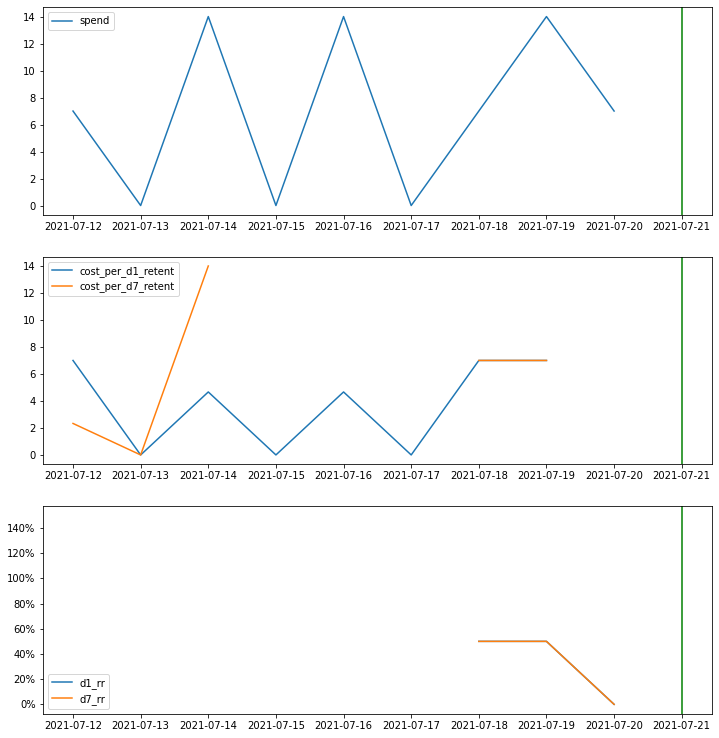

In [38]:
format_pivot.index = pd.to_datetime(format_pivot.index)
fig, ax = plt.subplots(3,1, figsize = (12,13))
ax[0].plot(format_pivot[['spend']])
ax[0].legend(['spend'])
ax[0].axvline(x = datetime.date(2021,7,21), color = 'green')
ax[1].plot(format_pivot[['cost_per_d1_retent','cost_per_d7_retent']])
ax[1].legend(['cost_per_d1_retent','cost_per_d7_retent'])
ax[1].axvline(x = datetime.date(2021,7,21), color = 'green')
ax[2].plot(format_pivot[['d1_rr','d7_rr']])
ax[2].legend(['d1_rr','d7_rr'])
ax[2].axvline(x = datetime.date(2021,7,21), color = 'green')
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))

# Look at <s>organics</s> totals


In [39]:
organic_df = bigquery_client.query(f"""
select
    date(t_created) as date 
    , count(distinct case when type = 'install' and event_name is null then ifa else NULL end)*16 as installs
    , count(distinct case when type = 'postback' and event_name = 'af_app_opened' then ifa else NULL end)*16 as opens
from external_data.ext_data 
where 
    date(t_created) >= '2021-06-01'
    and date(t_created) <= '{end_dt}'
    and bundle in ('1132762804','com.particlenews.newsbreak')
    and right(ifa,1) = '0'
group by 1
order by 1
""").to_dataframe()
organic_df

date  installs   opens
0   2021-06-24      8784  364304
1   2021-06-25      8032  358496
2   2021-06-26      8848  353328
3   2021-06-27      9120  356640
4   2021-06-28      8528  345056
5   2021-06-29      9312  353904
6   2021-06-30      8608  349984
7   2021-07-01      9056  359056
8   2021-07-02      9344  353392
9   2021-07-03      9360  349568
10  2021-07-04      8624  338384
11  2021-07-05      8432  348576
12  2021-07-06      8656  355056
13  2021-07-07      7936  348480
14  2021-07-08      7872  349712
15  2021-07-09      5200  345536
16  2021-07-10      7136  337008
17  2021-07-11      7072  341792
18  2021-07-12      7280  338912
19  2021-07-13      7904  345312
20  2021-07-14      7136  346480
21  2021-07-15      7056  343520
22  2021-07-16      7168  338672
23  2021-07-17      6448  331808
24  2021-07-18      6640  328608
25  2021-07-19      6208  325824
26  2021-07-20      6864  324416

<AxesSubplot:xlabel='date'>

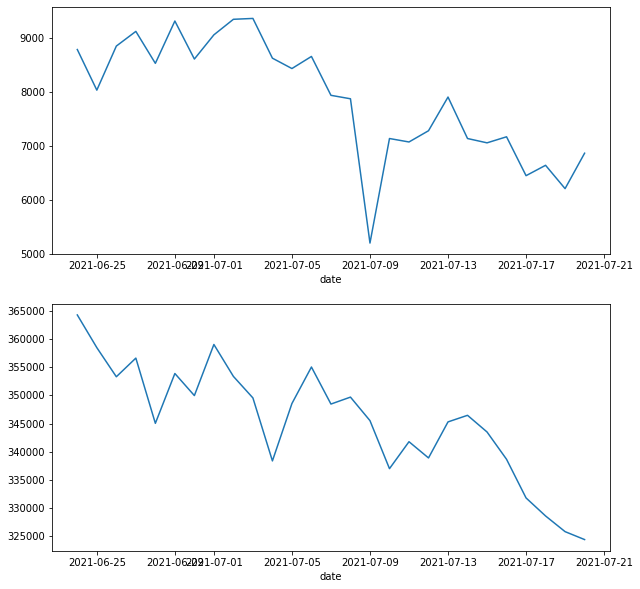

In [40]:
fig, ax = plt.subplots(2,1,figsize = (10,10))
organic_df.set_index('date')['installs'].plot(ax = ax[0])
organic_df.set_index('date')['opens'].plot(ax = ax[1])

Looks like overall opens have dropped significantly. This is likely the reason for the retention rate drop.

# overall optimizations

In [41]:
capped_campaigns = ['Particle Media - News Break - US - Tracfone PR',
'Particle Media - News Break - US - Tracfone UA',
'Particle Media - News Break - US - Cricket UA',
'Particle Media - News Break - US - ATT PR',
'Particle Media - News Break - US - Cricket PR',
'Particle Media - News Break - US - ATT UA',
'Particle Media - News Break - US - USCC PR',
'Particle Media - News Break - US - USCC UA']

In [42]:
filters = (df.campaign_name.isin(capped_campaigns)) & (df.edate < datetime.date(2021,7,20))
i = ['exchange_name']
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap = cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','cost_per_d1_retent','d7_rr','cost_per_d7_retent'])



In [43]:
i = ['impression type','ad_type']

filters = (df.campaign_name.isin(capped_campaigns)) & (df.edate < datetime.date(2021,7,20))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap = cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','cost_per_d1_retent','d7_rr','cost_per_d7_retent'])



In [44]:
i = ['exchange_name','impression type','ad_type']

filters = (df.campaign_name.isin(capped_campaigns)) & (df.edate < datetime.date(2021,7,20))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap = cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','cost_per_d1_retent','d7_rr','cost_per_d7_retent'])



In [45]:
i = ['model']

filters = (df.campaign_name.isin(capped_campaigns)) & (df.edate < datetime.date(2021,7,20))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(30).style.format(format_map).background_gradient(cmap = cm, subset = ['ctr','ir','ipm','cpm','rpi','margin','d1_rr','cost_per_d1_retent','d7_rr','cost_per_d7_retent'])



In [46]:
index_list = [['exchange_name'],['impression type','ad_type'], ['exchange_name','impression type','ad_type'], ['hosting_app_name'], 
['exchange_name','hosting_app_name'], ['os_major'], ['campaign_name'], ['campaign_name','exchange_name']]

with pd.ExcelWriter(f"~/Downloads/Newsbreak_optimization_{start_dt}_{end_dt}.xlsx") as writer:
    for i in index_list:
        filters = (df.campaign_name.isin(capped_campaigns)) & (df.edate < datetime.date(2021,7,20))
        pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = i, aggfunc = np.sum)
        format_pivot = calc_metrics(pivot)
        format_pivot.sort_values('spend', ascending = False, inplace = True)

        sheet_name = str(i).replace('[','').replace(']','').replace('\'','').replace('impression','imp').replace('_name','')
        format_pivot.head(100).to_excel(writer, sheet_name=sheet_name)



# comparing to other advertisers

In [53]:
df_comparison = bigquery_client.query(f"""
select
    r.date
    , extract(date from r.etimestamp) as edate
    , case when r.deal_id = 'Appreciate_Tripledot' then r.deal_id else NULL end as deal_id
    , case when r.ctr_model = 'production' or r.cr_model = 'production' then 'AP' else 'ML' end as model
    , c.name as campaign_name    
    , r.ssb_campaign_uuid
    , r.ssb_buyer_id
    , r.sponsored_app_id
    , r.exploration_uuid
    , p.name as sponsored_app_name
    , r.exchange_id
    , r.hosting_app_id
    , ho.name as hosting_app_name
    , p.bundle as sponsored_bnd
    , ad_type
    , imp_type
    , os_version_text
    , count(case when event_type = 'clear' then 1 else NULL end)*2 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*2 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*2 as installs
    , sum(case when event_type = 'install' then revenue else 0 end)*2 as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*2/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)*2/1000 as bid
    , 0 as d1_retent
    , 0 as d7_retent
from stats.rows1 r
join metadata.campaigns c
    on r.ssb_campaign_uuid = c.uuid  
    and (
        lower(c.name) like '%news break%'
        or lower(c.name) like '%smartnews%'
        or lower(c.name) like '%opera%'
    )
join metadata.apps p
    on r.sponsored_app_id = p.app_id
join metadata.apps ho
    on r.hosting_app_id = ho.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and right(r.id,1) in ('0','1','2','3','4','5','6','7')
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17

union all

select
    i.date
    , i.edate
    , i.deal_id
    , i.model
    , i.campaign_name    
    , i.ssb_campaign_uuid
    , i.ssb_buyer_id
    , i.sponsored_app_id
    , i.exploration_uuid
    , i.sponsored_app_name
    , i.exchange_id
    , i.hosting_app_id
    , i.hosting_app_name
    , i.sponsored_bnd
    , i.ad_type
    , i.imp_type
    , i.os_version_text
    , 0 as impressions
    , 0 as clicks
    , 0 as installs
    , 0 as spend
    , 0 as cost
    , 0 as bid
    , count(distinct case when date_diff(extract(date from r.etimestamp), i.date, day) = 1 then i.tid else NULL end) as d1_retent
    , count(distinct case when date_diff(extract(date from r.etimestamp), i.date, day) = 7 then i.tid else NULL end) as d7_retent
FROM `apprec-prod.stats.rows1` r
JOIN `apprec-prod.stats.mv_unique3` m
USING
  (id)
join
(
    select 
        r.id
        , r.tid
        , r.date
        , extract(date from r.etimestamp) as edate
        , case when r.deal_id = 'Appreciate_Tripledot' then r.deal_id else NULL end as deal_id
        , case when r.ctr_model = 'production' or r.cr_model = 'production' then 'AP' else 'ML' end as model
        , c.name as campaign_name    
        , r.ssb_campaign_uuid
        , r.ssb_buyer_id
        , r.sponsored_app_id
        , r.exploration_uuid
        , r.os_version_text
        , p.name as sponsored_app_name
        , r.exchange_id
        , r.hosting_app_id
        , ho.name as hosting_app_name
        , p.bundle as sponsored_bnd
        , ad_type
        , imp_type
    from stats.rows1 r
    join metadata.campaigns c
        on r.ssb_campaign_uuid = c.uuid  
        and (
            lower(c.name) like '%news break%'
            or lower(c.name) like '%smartnews%'
            or lower(c.name) like '%opera%'
        )
    join metadata.apps p
        on r.sponsored_app_id = p.app_id
    join metadata.apps ho
        on r.hosting_app_id = ho.app_id
    where 
        extract(date from etimestamp) >= '{start_dt}'
        and extract(date from etimestamp) <= '{end_dt}'
        and event_type = 'install'
        and r.ssb_buyer_id = 3549
) i 
    on r.id = i.id
WHERE
    m.date >= '{start_dt}' - 30
    and m.date <= '{end_dt}'
    and extract(date from r.etimestamp) >= '{start_dt}' 
    and extract(date from r.etimestamp) <= '{end_dt}' + 7
    and date_diff(extract(date from r.etimestamp), i.date, day) in (1,7)
    and r.event_type = 'pie' 
    and (lower(r.ename) like '%open%' or r.ename = 'session')
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
""").to_dataframe()
df_comparison = df_comparison.set_index('imp_type').join(imp_type.set_index('imp_type_id'), how = 'left').reset_index()
df_comparison = df_comparison.set_index('exchange_id').join(exchange.set_index('exchange_id'), how = 'left').reset_index()
df_comparison['experience_type'] = df_comparison.apply(lambda x:classify_campaigns(x), axis = 1)
df_comparison['media_cost'] = 1.25*df_comparison['cost']
df_comparison['week'] = pd.to_datetime(df_comparison['date']).dt.week
df_comparison['eweek'] = pd.to_datetime(df_comparison['edate']).dt.week
df_comparison

exchange_id  index        date       edate               deal_id  \
0                  1    1.0  2021-07-15  2021-07-15  Appreciate_Tripledot   
1                  1    1.0  2021-07-15  2021-07-15  Appreciate_Tripledot   
2                  1    1.0  2021-07-07  2021-07-07  Appreciate_Tripledot   
3                  1    1.0  2021-07-07  2021-07-07  Appreciate_Tripledot   
4                  1    1.0  2021-07-15  2021-07-15  Appreciate_Tripledot   
...              ...    ...         ...         ...                   ...   
6254830           59   16.0  2021-07-06  2021-07-06                  None   
6254831           59   16.0  2021-07-10  2021-07-10                  None   
6254832           59   16.0  2021-07-02  2021-07-02                  None   
6254833           59   16.0  2021-07-01  2021-07-01                  None   
6254834           59   16.0  2021-07-05  2021-07-05                  None   

        model                                      campaign_name  \
0          AP  Particle Media – News Break – US – All – GP2 -...   
1          AP  Particle Media – News Break – US – All – GP2 -...   
2          AP  Particle Media – News Break – US – All – GP2 -...   
3          AP  Particle Media – News Break – US – All – GP2 -...   
4          AP  Particle Media – News Break – US – All – GP2 -...   
...       ...                                                ...   
6254830    ML            SmartNews_Tracfone_SingleTap_All_CPI_NA   
6254831    ML            SmartNews_Tracfone_SingleTap_All_CPI_NA   
6254832    ML            SmartNews_Tracfone_SingleTap_All_CPI_NA   
6254833    ML            SmartNews_Tracfone_SingleTap_All_CPI_NA   
6254834    ML            SmartNews_Tracfone_SingleTap_All_CPI_NA   

                        ssb_campaign_uuid  ssb_buyer_id  sponsored_app_id  \
0        6d5f7270a4335e186b77a6c6d3cc5161          3549            951372   
1        6d5f7270a4335e186b77a6c6d3cc5161          3549            951372   
2        6d5f7270a4335e186b77a6c6d3cc5161          3549            951372   
3        6d5f7270a4335e186b77a6c6d3cc5161          3549            951372   
4        6d5f7270a4335e186b77a6c6d3cc5161          3549            951372   
...                                   ...           ...               ...   
6254830  d8be47c87ebd5047c552f92421103f1a          3549            579401   
6254831  d8be47c87ebd5047c552f92421103f1a          3549            579401   
6254832  d8be47c87ebd5047c552f92421103f1a          3549            579401   
6254833  d8be47c87ebd5047c552f92421103f1a          3549            579401   
6254834  d8be47c87ebd5047c552f92421103f1a          3549            579401   

         ...      cost       bid  d1_retent d7_retent impression type  \
0        ...  0.003004  0.003004          0         0         display   
1        ...  0.011438  0.011438          0         0         display   
2        ...  0.000258  0.000260          0         0         display   
3        ...  0.001291  0.001300          0         0         display   
4        ...  0.010036  0.010036          0         0         display   
...      ...       ...       ...        ...       ...             ...   
6254830  ...  0.059786  0.059786          0         0  rewarded video   
6254831  ...  0.078692  0.078692          0         0  rewarded video   
6254832  ...  0.063248  0.063249          0         0  rewarded video   
6254833  ...  0.071268  0.071267          0         0  rewarded video   
6254834  ...  0.046574  0.046574          0         0  rewarded video   

        exchange_name experience_type  media_cost  week  eweek  
0               Fyber               3    0.003755    28     28  
1               Fyber               3    0.014298    28     28  
2               Fyber               3    0.000322    27     27  
3               Fyber               3    0.001614    27     27  
4               Fyber               3    0.012545    28     28  
...               ...             ...         ...   ...    ...  
6254830   

In [56]:
df_comparison.groupby('sponsored_bnd')['d1_retent','d7_retent'].sum()

d1_retent  d7_retent
sponsored_bnd                                   
1132762804                         59         36
com.opera.app.news               9096       5708
com.particlenews.newsbreak      72438      55178
jp.gocro.smartnews.android       7380      27506

In [58]:
index_list = [[],['exchange_name'],['impression type','ad_type'], ['exchange_name','impression type','ad_type'], ['hosting_app_name'], 
['exchange_name','hosting_app_name'], ['campaign_name'], ['campaign_name','exchange_name']]

with pd.ExcelWriter(f"~/Downloads/Newsbreak_otheradvcomparison_optimization_{start_dt}_{end_dt}.xlsx") as writer:
    for i in index_list:
        filters = (df_comparison.edate < datetime.date(2021,7,20))
        pivot = df_comparison[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost','d1_retent','d7_retent'], index = ['sponsored_bnd'] + i, aggfunc = np.sum)
        format_pivot = calc_metrics(pivot)
        format_pivot.sort_values('spend', ascending = False, inplace = True)

        sheet_name = str(i).replace('[','').replace(']','').replace('\'','').replace('impression','imp').replace('_name','')
        format_pivot.head(10000).to_excel(writer, sheet_name=sheet_name)


